In [1]:
# Import important libraries

import numpy as np  # handling matrix operations
import pandas as pd  # data handling and preprocessing
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # data visualization
import matplotlib.colors as colors # coloring plots

# Problem-1

Broad Objectives:
- Train PCA on the given dataset
- Train Kernel PCA on the given dataset
- Study the performance of various kernels

## Data preprocessing & EDA

In [2]:
# Load dataset and assign column names

df1 = pd.read_csv('Dataset_1.csv', header=None, names=['x', 'y'])

          x         y
0  2.060319  2.316620
1  3.426071  2.282277
2  3.464442  0.716318
3  2.982301  3.256476
4  0.986488  0.758411
                 x            y
count  1000.000000  1000.000000
mean      1.500568     1.499394
std       1.109979     1.125431
min      -1.117415    -1.423498
25%       0.780289     0.755893
50%       1.494296     1.499006
75%       2.222607     2.239443
max       4.118185     4.439246


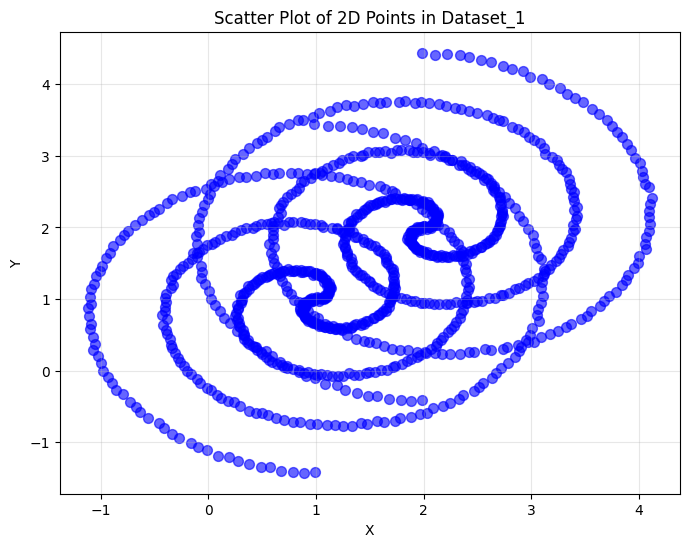

In [3]:
# Carry out exploratory data analysis for Dataset_1
print(df1.head())
print(df1.describe())

# Visualize the dataset in 2D
plt.figure(figsize=(8, 6))
plt.scatter(df1['x'], df1['y'], alpha=0.6, color='blue', s=50)
plt.xlabel('X')
plt.ylabel('Y') 
plt.title('Scatter Plot of 2D Points in Dataset_1')
plt.grid(True, alpha=0.3)
plt.show()

Obtain matrix X from the dataset

Every row of X is a 2D sample with X & Y coordinate values

In [4]:
X = df1[['x', 'y']].values
print(X)

[[2.06031874 2.31662042]
 [3.42607063 2.28227718]
 [3.46444152 0.71631786]
 ...
 [1.07821154 1.03076394]
 [0.94100354 0.95712182]
 [2.95546409 0.43090975]]


## Implement custom PCA class

In [5]:
class PCA:
    # Initialize
    def __init__(self, n_components = None):
        self.n_components = n_components    # number of principal components
        self.components = None  # principal components
        self.mean = None    # mean of the data
        self.explained_variance = None  # eigen values, variance captured by each PC
        self.explained_variance_ratio = None    # eigen values ratio

    # fit PCA on the data & obtain PC directions
    def fit(self, X):
        # Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # calculate covariance matrix as X*X^T
        Covariance_matrix = X_centered.T @ X_centered

        # calculate eigen values and eigen vectors
        # eigen vectors are sorted in ascending order by their respective eigen values
        eigen_values, eigen_vectors = np.linalg.eigh(Covariance_matrix)
        
        # sort the eigen values and eigen vectors in descending order of eigen values
        eigen_values = eigen_values[::-1]
        eigen_vectors = eigen_vectors[:, ::-1]
        
        # Extract (if specified) the top 'n_components' eigen vectors
        if self.n_components:
            eigen_values = eigen_values[:self.n_components]
            eigen_vectors = eigen_vectors[:, :self.n_components]

        # here eigen_vectors[0] is the 1st principal component
        # eigen_vectors[1] is the 2nd principal component
        # and so on

        # assign values to class variables
        self.explained_variance = eigen_values
        self.explained_variance_ratio = eigen_values / np.sum(eigen_values)
        self.components = eigen_vectors.T
    
    # project data onto the PCs
    def transform(self, X):
        X_centered = X - self.mean
        return X_centered @ self.components.T
    
    # combines fit & transform in single step
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

Apply PCA to the dataset and observe the explained variance ratio.

In [6]:
pca = PCA()
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio)

[0.65393723 0.34606277]


PC1 explains 65.4% variance\
PC2 explains 34.6% variance

Create a bar plot to visualize the explained variance ratio of each component

## Implement custom Kernel PCA class

In [7]:
class KernelPCA:
    # Initialize
    def __init__(self, n_components=None, kernel='linear', degree=1, gamma=1, coef0=1):
        
        self.n_components = n_components # number of components to project along
        self.kernel = kernel # kernel function to be used
        self.degree = degree 
        self.gamma = gamma
        self.coef0 = coef0 

        # to calculate inner product as per the kernel function used
        self.kernel_map = {'linear': lambda x, y: x.T @ y,
                            'polynomial': lambda x, y: (self.gamma*(x.T @ y) + self.coef0)**self.degree,
                            'rbf': lambda x, y: np.exp(-self.gamma*np.linalg.norm(x-y)**2)}
        
        self.components = None # principal components to project along
        self.explained_variance = None # eigen values

        # for rbf kernel
        if self.kernel == 'rbf':
            self.rbf_variance = 1/(2*self.gamma)**0.5 # variance is obtained from gamma
    
    # Combining fit & transformation of the data
    def fit_transform(self, X):
        n_samples = X.shape[0]

        # init kernel matrix
        K = np.zeros((n_samples, n_samples))
        
        # 1n matrix to be used for centering the kernel matrix
        one_n = np.ones((n_samples, n_samples)) / n_samples 

        # populate kernel matrix by calculating the inner product for each pair of data points 
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel_map[self.kernel](X[i], X[j])
        
        # center the kernel matrix
        K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

        # compute eigen values and eigen vectors
        # eigen vectors (β's) are arranged in ascending order of respect to eigen values
        eigen_values, eigen_vectors = np.linalg.eigh(K_centered)
        
        # reverse the order of eigen values and eigen vectors
        eigen_values = eigen_values[::-1]
        eigen_vectors = eigen_vectors[:,::-1]

        # if n_components is specified, reduce the number of components
        if self.n_components:
            eigen_values = eigen_values[:self.n_components]
            eigen_vectors = eigen_vectors[:, :self.n_components]
            
        # Normalize eigenvectors by square root of eigenvalues
        # as α = β/√λ
        for i in range(self.n_components):
            eigen_vectors[:, i] = eigen_vectors[:, i] / np.sqrt(eigen_values[i])
        
        # store the required components and eigen values
        self.components = eigen_vectors
        self.eigenvalues = eigen_values

        # explained variance ratio of the PC's obtained from transformed linear space
        self.explained_variance_ratio = eigen_values / np.sum(eigen_values)
        
        # transform the data by directly projecting it on the PC's from transformed linear space
        return K_centered @ self.components        

Use polynomial & RBF kernels with varying values of degree & σ and plot projections along first 2 principal components in the kernel transformed linear space

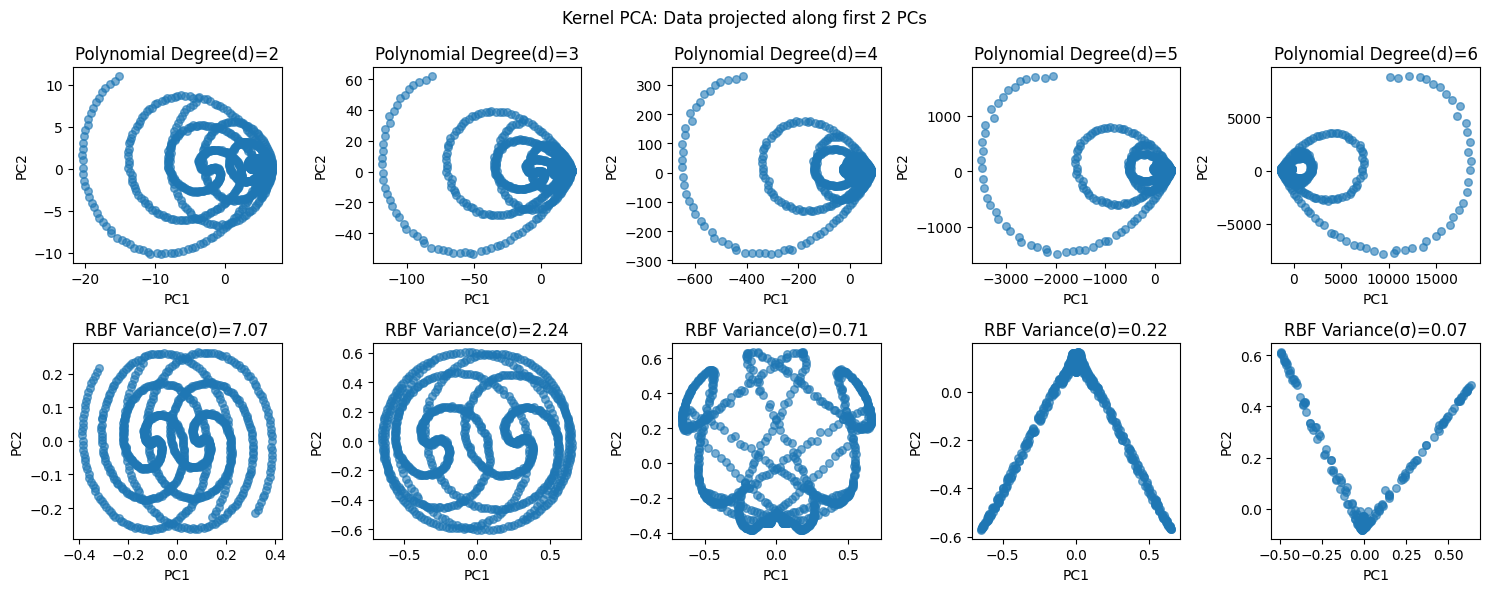

In [8]:
# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Kernel PCA: Data projected along first 2 PC''s')

# Plot the projections along first 2 PC's

# Polynomial kernel with different degrees
degrees = [2, 3, 4, 5, 6]
for i, degree in enumerate(degrees):
    kpca = KernelPCA(n_components=2, kernel='polynomial', degree=degree, gamma=1.0)
    X_proj = kpca.fit_transform(X)
    axes[0, i].scatter(X_proj[:, 0], X_proj[:, 1], alpha=0.6, s=30)
    axes[0, i].set_title(f'Polynomial Degree(d)={degree}')
    axes[0, i].set_xlabel('PC1')
    axes[0, i].set_ylabel('PC2')

# RBF kernel with different gamma (variance,σ) values  
gammas = [0.01, 0.1, 1.0, 10.0, 100.0]
for i, gamma in enumerate(gammas):
    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
    X_proj = kpca.fit_transform(X)
    axes[1, i].scatter(X_proj[:, 0], X_proj[:, 1], alpha=0.6, s=30)
    axes[1, i].set_title(f'RBF Variance(σ)={kpca.rbf_variance:.2f}')
    axes[1, i].set_xlabel('PC1')
    axes[1, i].set_ylabel('PC2')

plt.tight_layout()
plt.show()

We use RBF kernel to transform the data and evaluate the performance by varying the variance of the kernel (using gamma).

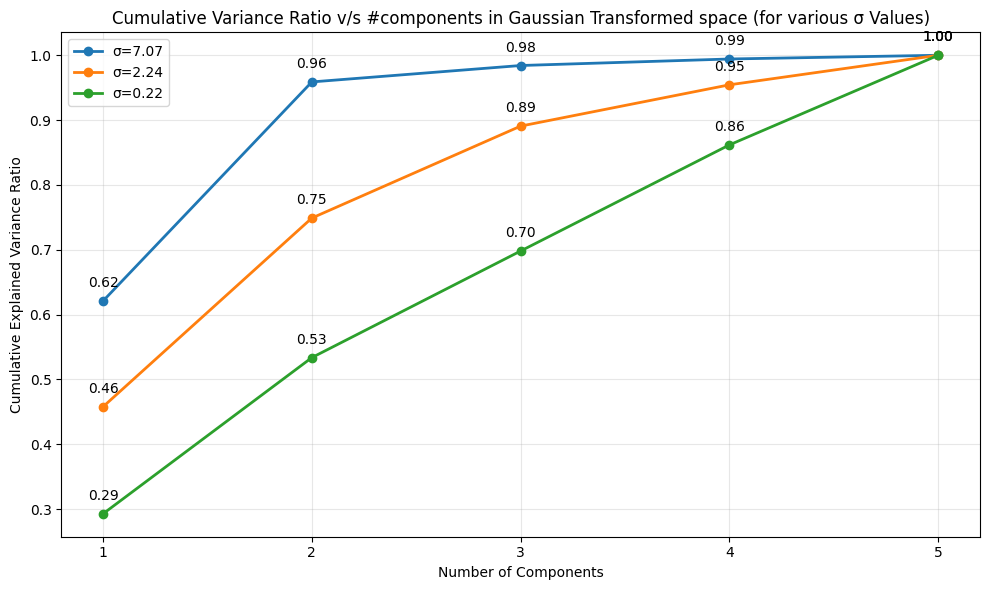

In [9]:
# Test different gamma values
gammas = [0.01, 0.1, 10.0]
components = np.arange(1, 6)

plt.figure(figsize=(10, 6))

for gamma in gammas:
    kpca = KernelPCA(kernel='rbf', n_components=5, gamma=gamma)
    kpca.fit_transform(X)
    
    # Calculate cumulative variance ratio
    
    line = plt.plot(components, np.cumsum(kpca.explained_variance_ratio), 'o-', label=f'σ={kpca.rbf_variance:.2f}', linewidth=2, markersize=6)[0]
    
    # Add value labels for the first gamma (top most line)
    for i, value in enumerate(np.cumsum(kpca.explained_variance_ratio)):
        plt.annotate(f'{value:.2f}', 
                    (components[i], value),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Variance Ratio v/s #components in Gaussian Transformed space (for various σ Values)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(components)
plt.tight_layout()
plt.show()

## Observations
- On transforming the data using RBF kernel with relatively high value of variance (i.e., σ = 7.07), the projections along the first 2 principal components account for 96% of the variance in the data.

- If we further increase the value of σ, the first 2 PC's will account for even more variance in the data.

- Best suited kernel: (Therefore) any RBF kernel with σ >= 7 is the best suited kernel for transforming this dataset.

# Problem-2

## Data preprocessing and EDA

In [10]:
# Load the Dataset_2

df2 = pd.read_csv('Dataset_2.csv', header=None, names=['x', 'y'])

         x        y
0  0.14300  0.98493
1 -0.30467  0.98562
2  0.46625 -0.84003
3  0.94847  0.37222
4 -0.96871 -0.26697
                  x             y
count  1.000000e+03  1.000000e+03
mean   4.075000e-07  2.227000e-07
std    3.844598e+00  4.107583e+00
min   -9.494100e+00 -8.836600e+00
25%   -2.021900e+00 -2.391100e+00
50%    7.883000e-02  1.096400e-01
75%    2.468000e+00  2.414475e+00
max    8.566400e+00  9.172600e+00


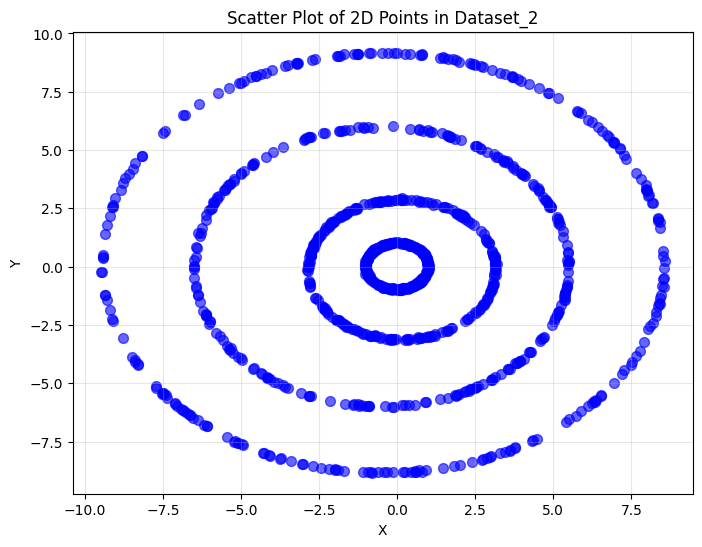

In [11]:
# Carry out exploratory data analysis for Dataset_1
print(df2.head())
print(df2.describe())

# Visualize the dataset in 2D
plt.figure(figsize=(8, 6))
plt.scatter(df2['x'], df2['y'], alpha=0.6, color='blue', s=50)
plt.xlabel('X')
plt.ylabel('Y') 
plt.title('Scatter Plot of 2D Points in Dataset_2')
plt.grid(True, alpha=0.3)
plt.show()

Obtain matrix X from the dataset

Every row of X is a 2D sample with X & Y coordinate values

In [12]:
X = df2[['x', 'y']].values
print(X)

[[ 0.143    0.98493]
 [-0.30467  0.98562]
 [ 0.46625 -0.84003]
 ...
 [ 6.1062  -5.9864 ]
 [-7.4094  -5.5205 ]
 [-0.12948 -8.8036 ]]


## Implement custom KMeans class

It supports random and kmeans++ initialization

In [13]:
class KMeans:
    # Initialize
    def __init__(self, n_clusters=2, tol=0.001, random_state=None, init='random'):
        
        self.n_clusters = n_clusters
        self.tol = tol  # tolerance value for convergence
        self.random_state = random_state    # for reproducibility of random sampling of centroids
        self.centroids = None   # store the final cluster centers
        self.labels = None      # store the cluster labels for each data point
        self.init = init    # init technique (random or kmeans++)
        self.wcss = []  # stores the within-cluster sum of square errors for each iteration

    # Assigns data points to cluster corresponding to the closest centroid
    # Returns the cluster labels for each data point
    def assign(self, X):
        # Compute pairwise distances: shape (n_samples, n_clusters)
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        return labels

    # Updates the centroids after assigning data points to clusters
    # Returns the new centroids which are means of all the points in each cluster
    def update(self, X, labels):
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
        return new_centroids

    # Initialize the centroids
    # If seed_centroids is provided, uses them as initial/seed centroids
    # Otherwise, uses random sampling or k-means++ sampling as specified during instance creation
    def init_centroids(self, X, seed_centroids=None):

        if seed_centroids is not None:
            # ensure the number of seed centroids matches the number of clusters specified
            assert self.n_clusters == seed_centroids.shape[0]
            self.centroids = seed_centroids
        
        # if no seed centroids are provided
        else:
            # set random state for reproducibility in case of random sampling of means from the data
            if self.random_state:
                np.random.seed(self.random_state)
            
            # init centroids through randomly sampling (without replacement) from the data
            if self.init == 'random':
                self.centroids = X[np.random.choice(len(X), self.n_clusters, replace=False)]
            
            # init centroids using K-means++ technique
            elif self.init == 'kmeans++':
                # select first centroid randomly
                first_idx = np.random.choice(len(X))
                self.centroids = [X[first_idx]]

                # Select remaining centroids with probability proportional to 
                # minimum distance to existing centroids
                for _ in range(1, self.n_clusters):
                    # Calculate distances to closest centroid for each point
                    distances = np.array([
                        min([np.linalg.norm(x - c)**2 for c in self.centroids]) 
                        for x in X
                    ])
                    
                    # Convert distances to probabilities
                    probs = distances / distances.sum()
                    
                    # Choose next centroid
                    next_idx = np.random.choice(len(X), p=probs)
                    # add the next centroid to the init centroids list
                    self.centroids.append(X[next_idx])
            
                self.centroids = np.array(self.centroids)

    # Fits the KMeans model to the data using the specified number of clusters
    def fit(self, X, seed_centroids=None):        

        # initialize the centroids using the specified technique (random/kmeans++)
        self.init_centroids(X, seed_centroids)

        # Iteratively run the Lloyd's algorithm until the convergence criterion is met
        centroid_shift = np.inf
        while centroid_shift > self.tol:
            labels = self.assign(X)
            new_centroids = self.update(X, labels)
            centroid_shift = np.linalg.norm(self.centroids - new_centroids, axis=1).max()
            self.centroids = new_centroids
            
            # Calculate within-cluster sum of square distances for each iteration
            wcss = 0
            for i in range(self.n_clusters):
                cluster_points = X[labels == i]
                if len(cluster_points) > 0:
                    wcss += np.sum(np.square(np.linalg.norm(cluster_points - self.centroids[i], axis=1)))
            self.wcss.append(wcss)
        
        # final cluster labels for each data point
        self.labels = labels

    # Fits the KMeans model to the data and returns the cluster labels
    def fit_predict(self, X, seed_centroids=None):
        self.fit(X, seed_centroids)
        return self.labels
    
    # Predicts the cluster labels for new data points
    def predict(self, X):
        return self.assign(X)

## Kmeans for random initialization

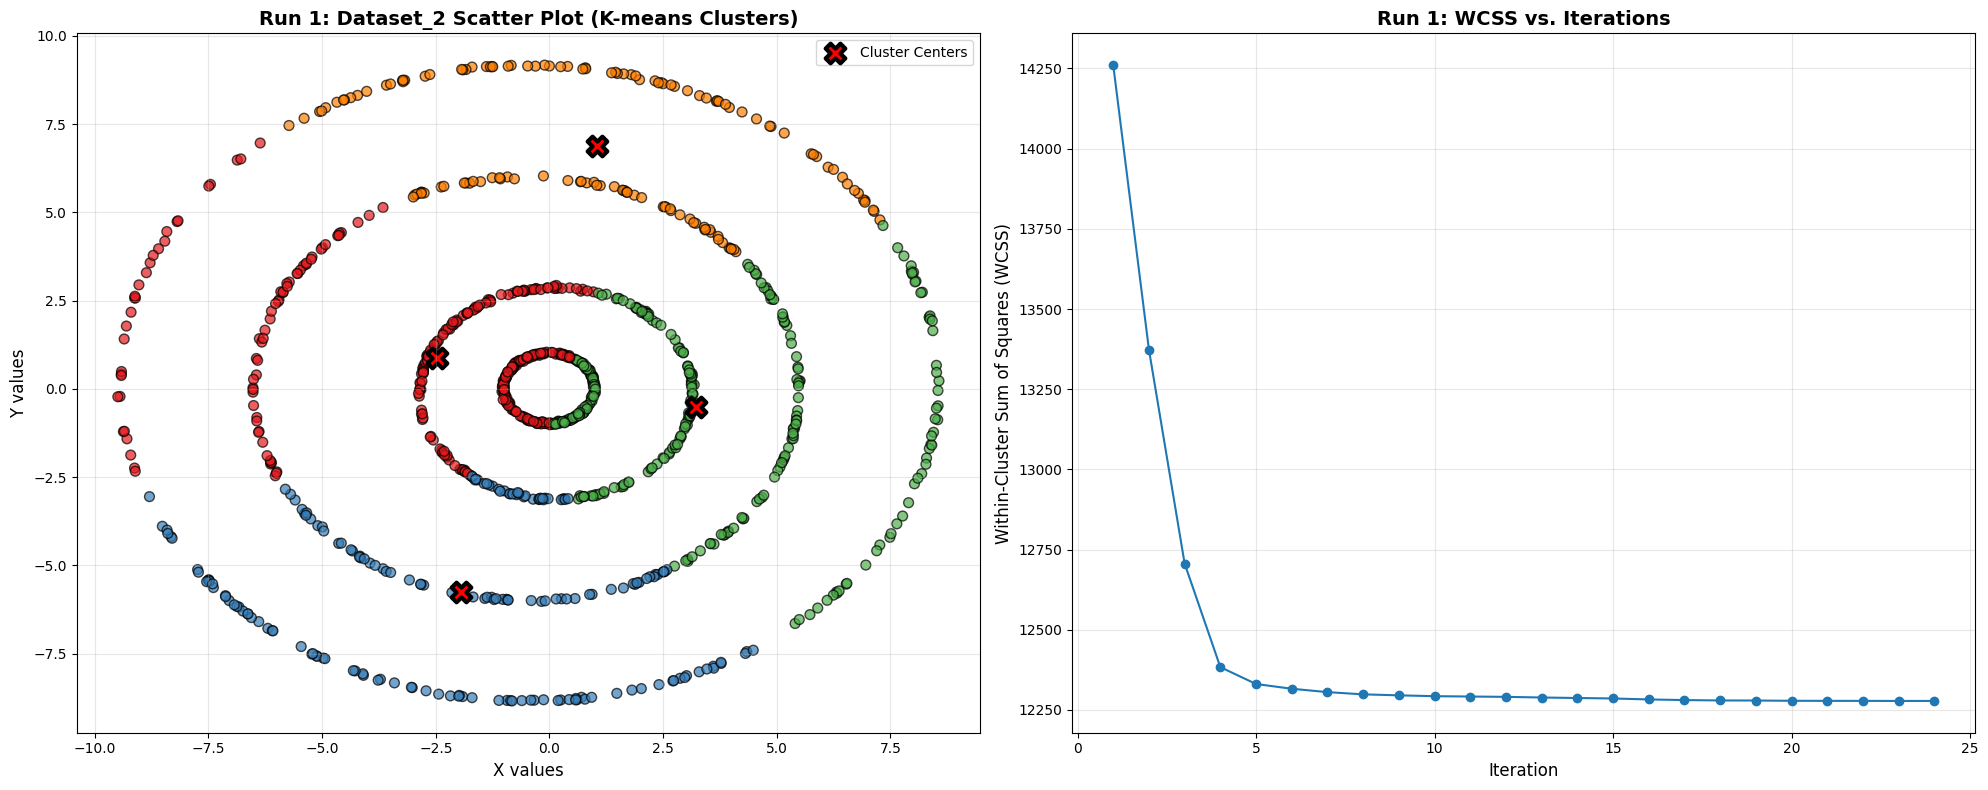

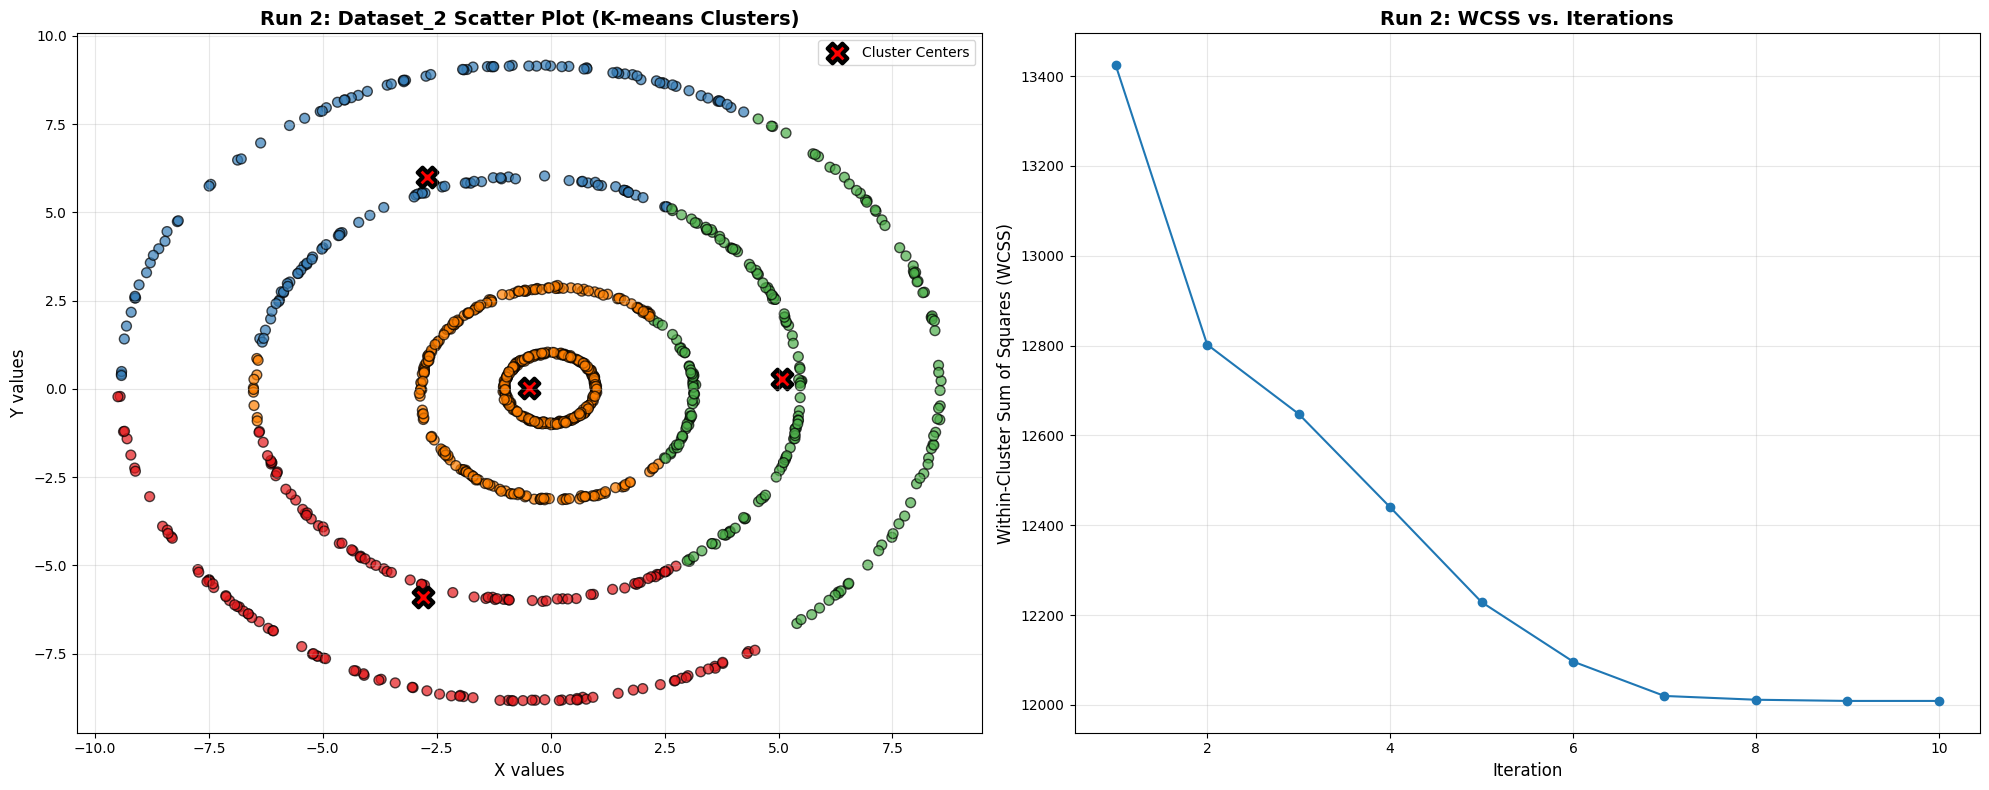

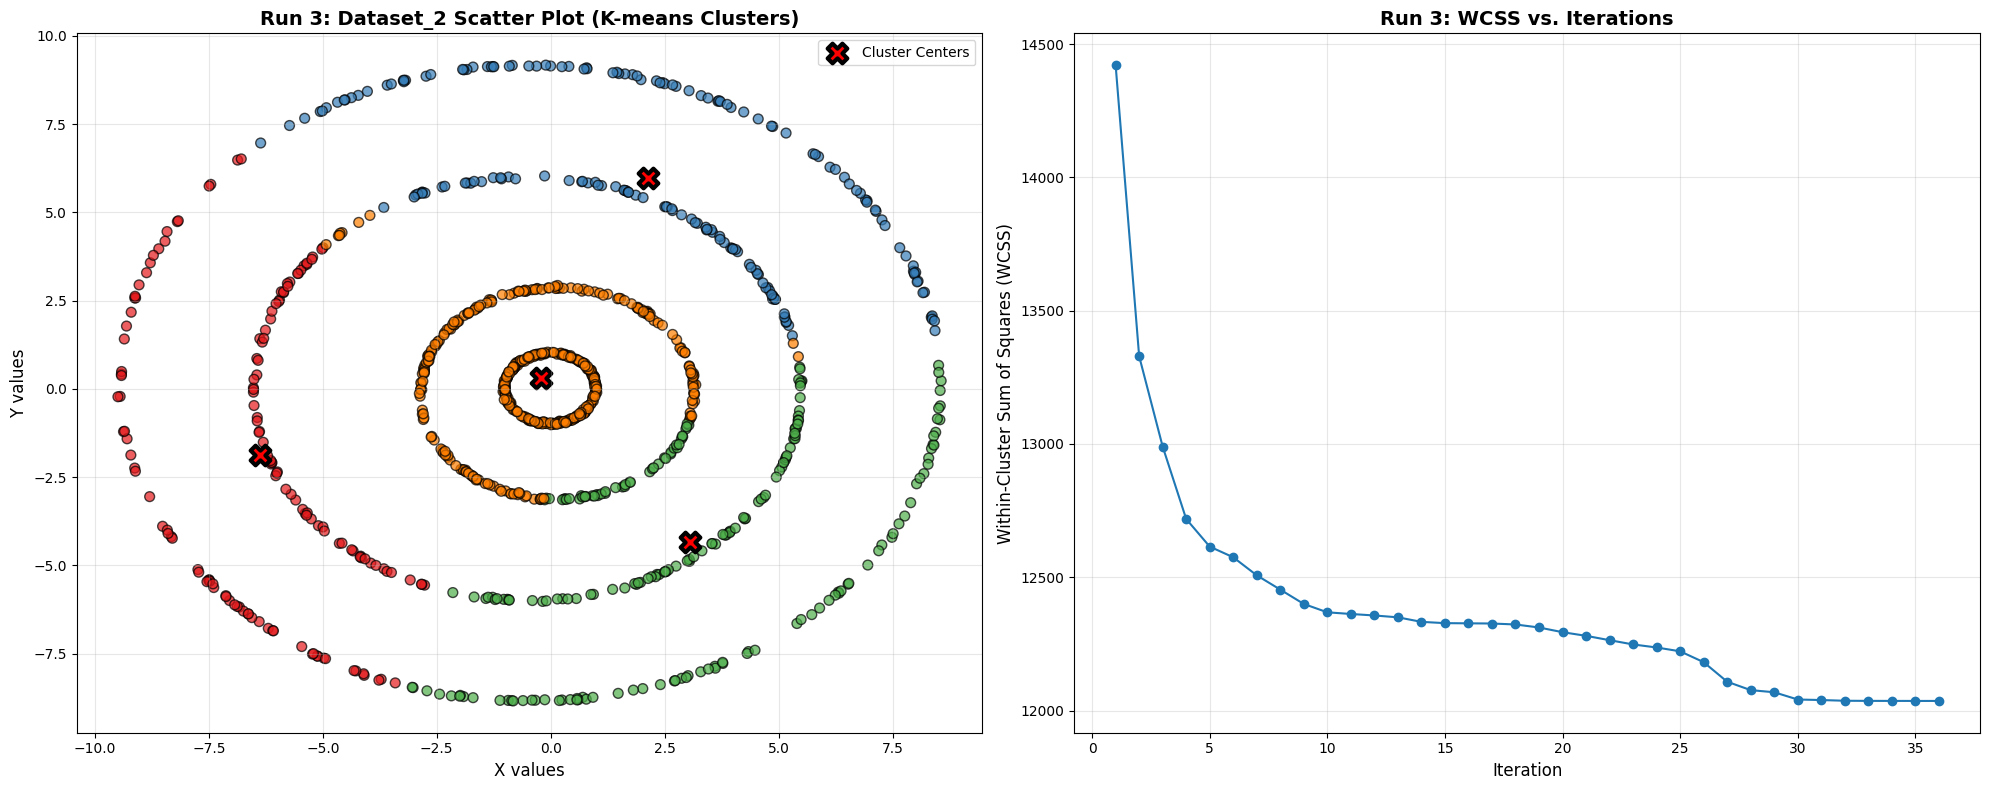

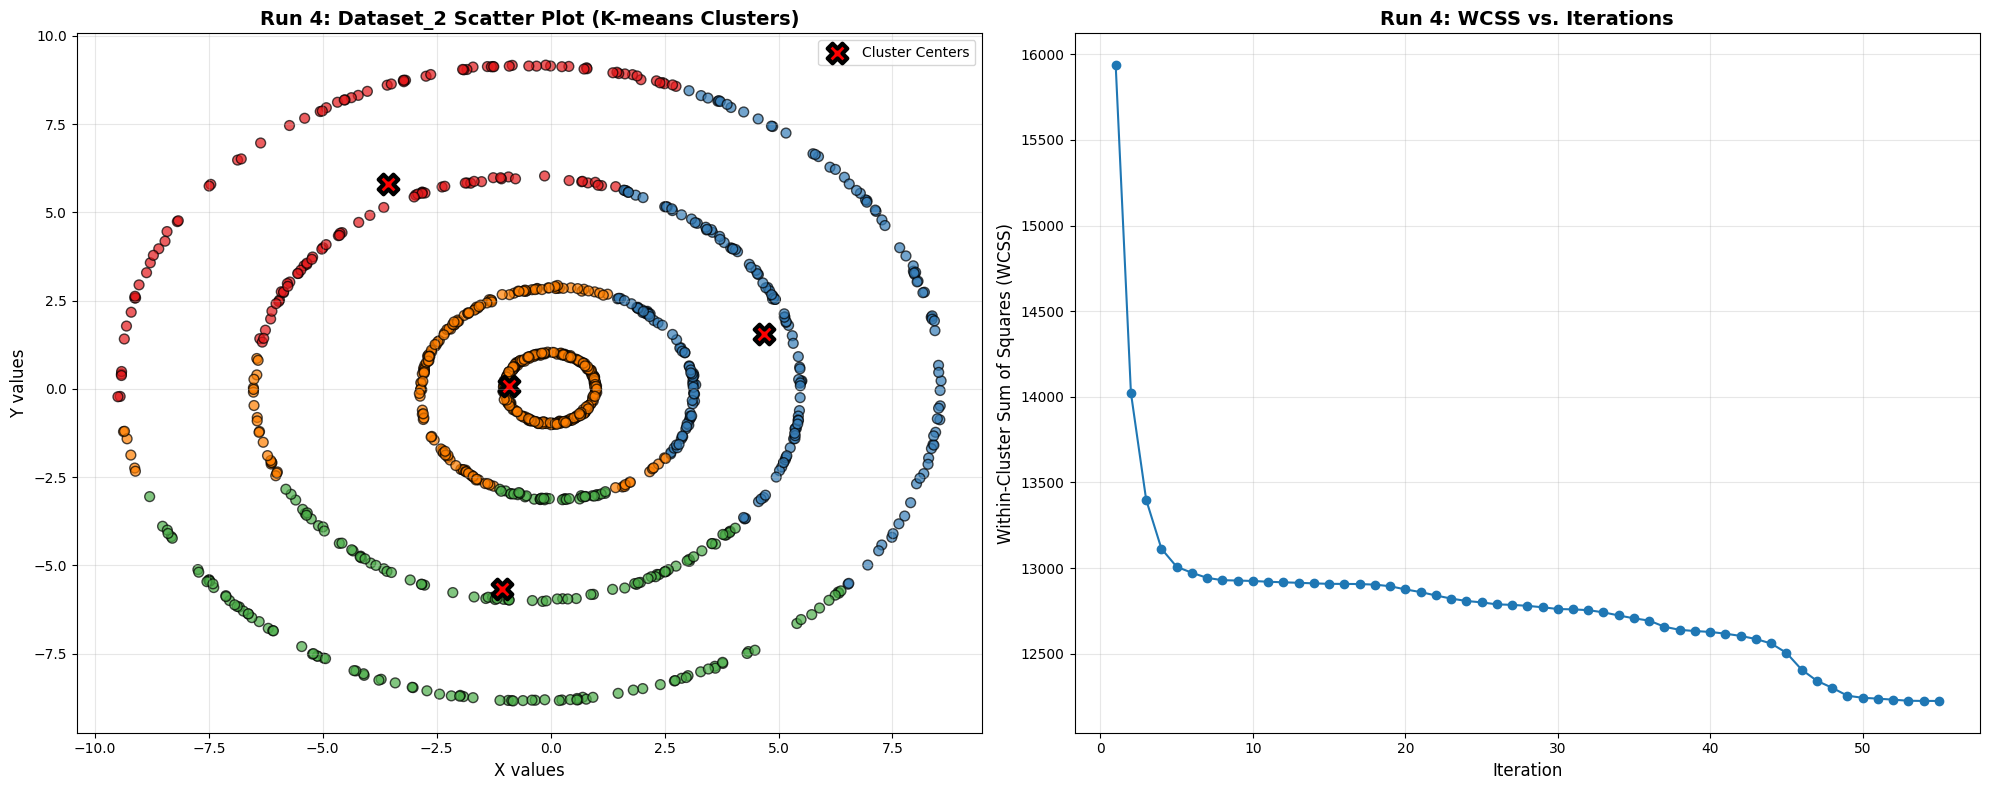

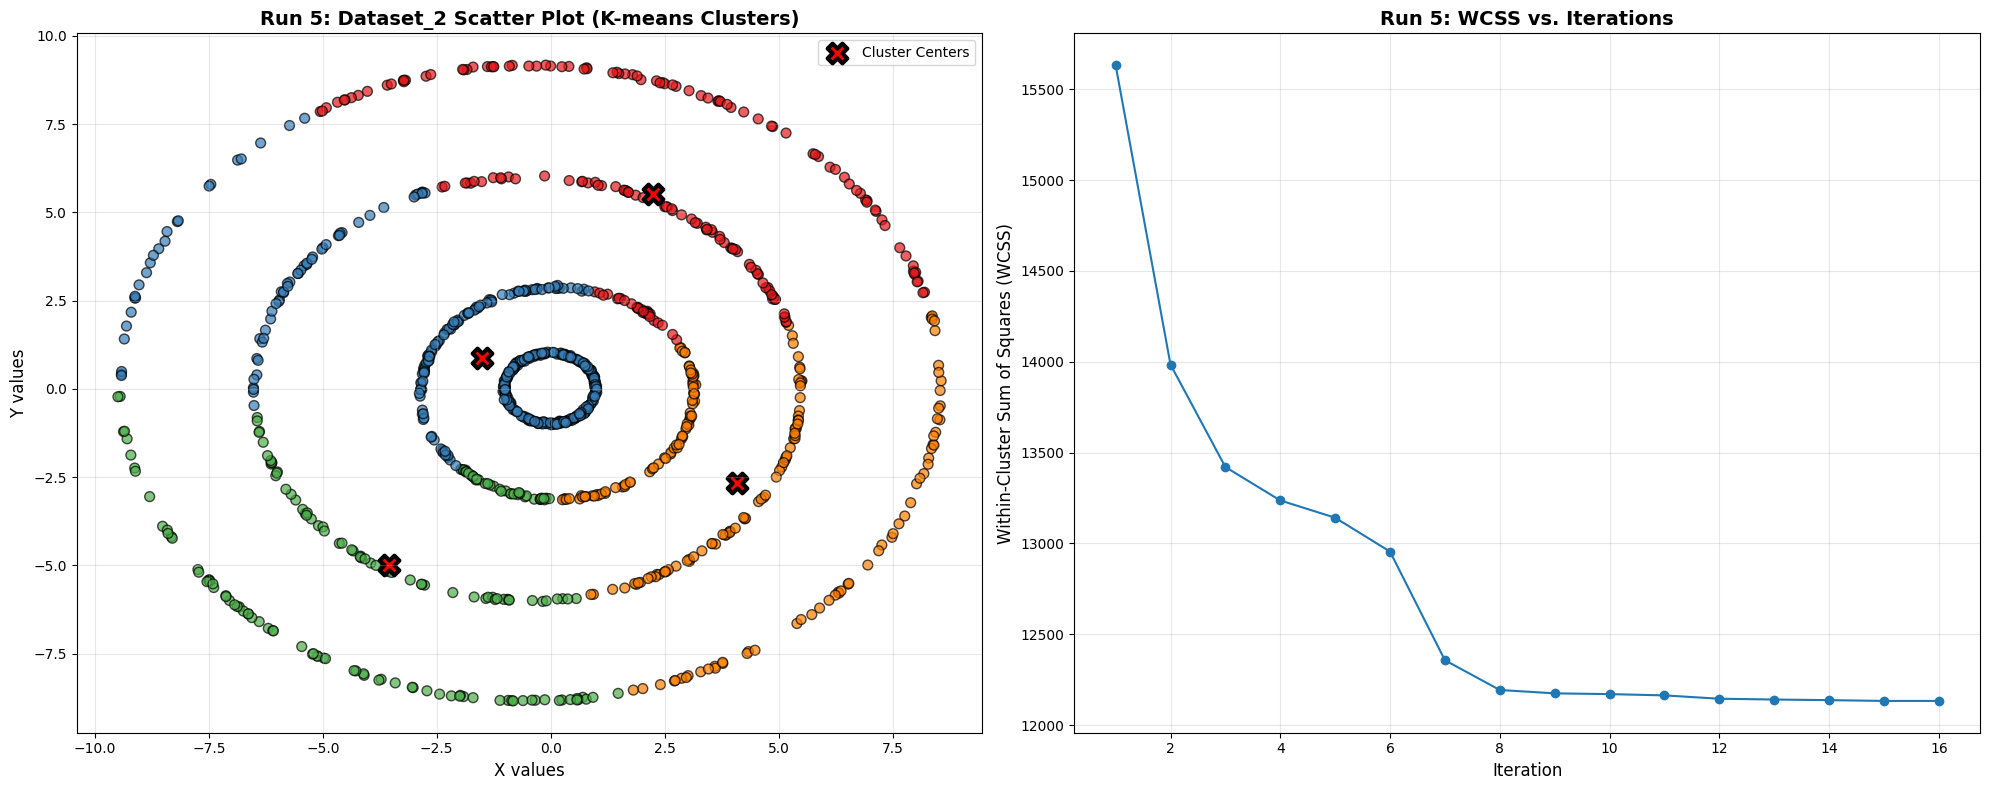

In [14]:
# Initialize lists to store WCSS and labels for multiple runs
all_wcss = []
all_labels = []
all_centroids = []

# Run K-means with 5 different random initializations
for i in range(5):
    # Set different random state for each run
    kmeans = KMeans(n_clusters=4, random_state=i*10)
    labels = kmeans.fit_predict(X)
    
    # Store the WCSS, labels, and centroids for each run
    all_wcss.append(kmeans.wcss)
    all_labels.append(labels)
    all_centroids.append(kmeans.centroids)
    
    # Create figure with subplots: scatter plot and WCSS plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Scatter plot
    custom_colors = ["#E41A1C", "#377EB8", "#4DAF4A", "#FF7F00"]  # Custom colors
    scatter = ax1.scatter(df2['x'], df2['y'], c=labels, cmap=colors.ListedColormap(custom_colors), 
                         alpha=0.7, edgecolors='black', s=50)
    
    # Add cluster centers
    centers = kmeans.centroids
    ax1.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, 
               linewidths=3, edgecolors='black', label='Cluster Centers')
    
    ax1.set_title(f'Run {i+1}: Dataset_2 Scatter Plot (K-means Clusters)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('X values', fontsize=12)
    ax1.set_ylabel('Y values', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # WCSS plot
    ax2.plot(range(1, len(kmeans.wcss)+1), kmeans.wcss, marker='o', linestyle='-')
    ax2.set_title(f'Run {i+1}: WCSS vs. Iterations', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## KMeans for fixed initialization

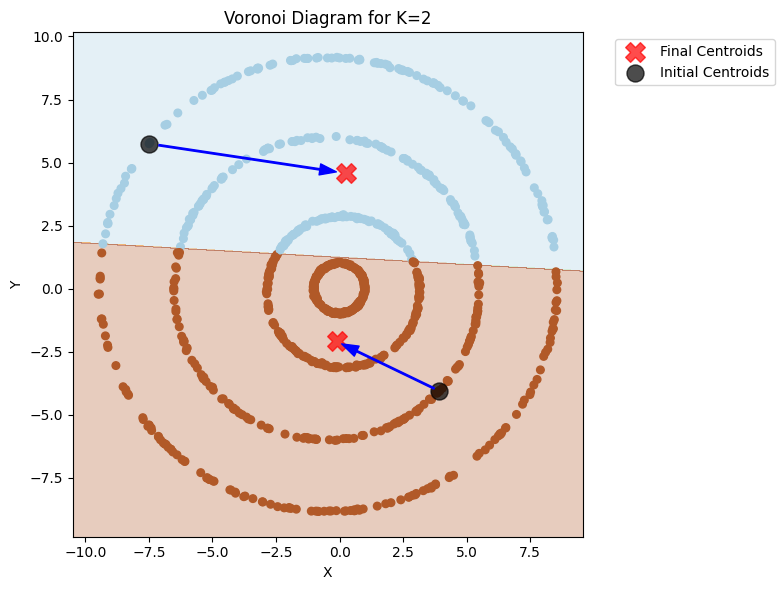

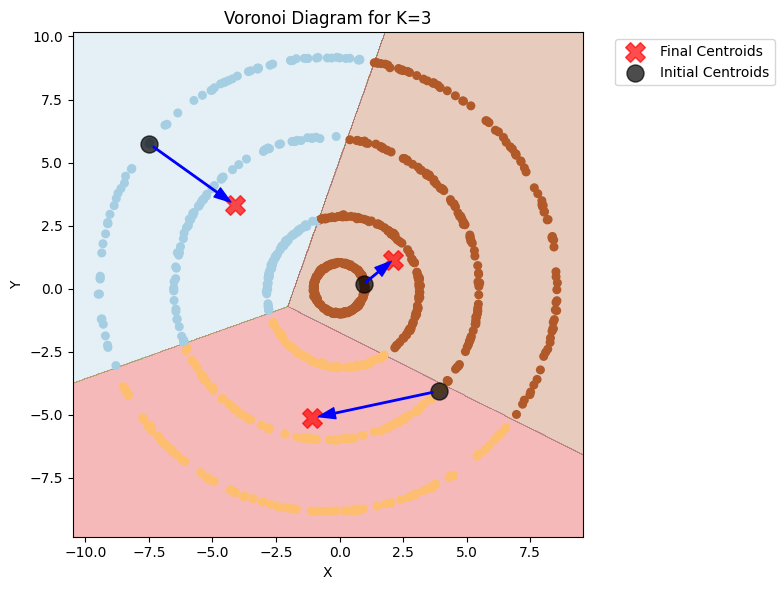

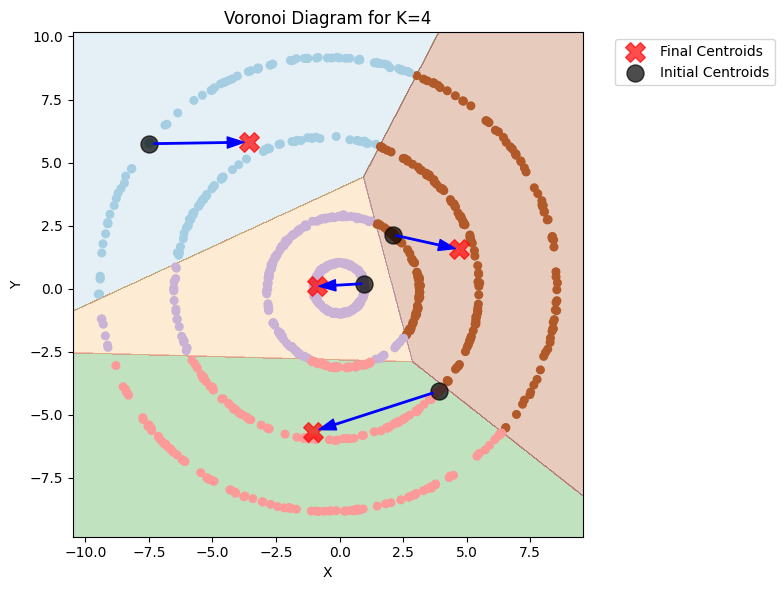

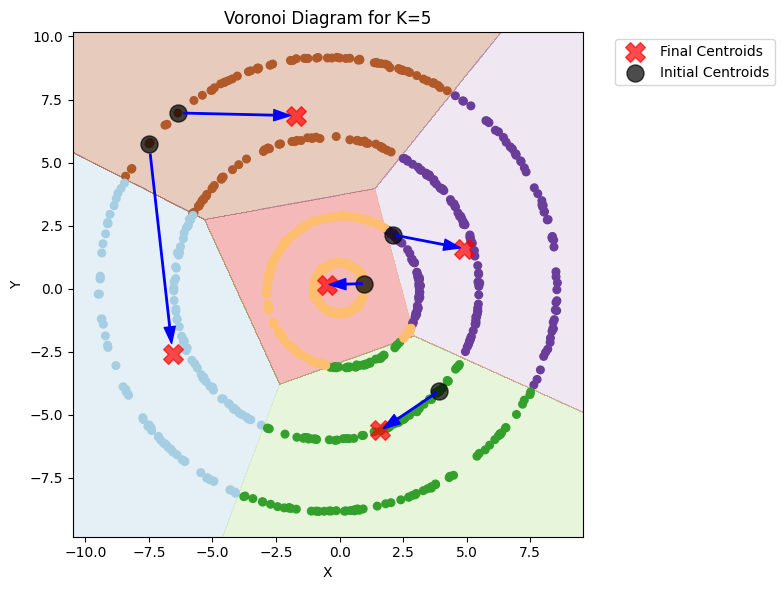

In [15]:
# Randomly sample 5 distinct data points from X
centroid_indices = np.random.choice(X.shape[0], size=5, replace=False)
# Store the data points
# Now, we have fixed the centroids
centroid_points = X[centroid_indices]

# Loop through different values of K
for k in range(2, 6):

    # Apply KMeans clustering using the fixed initialization above
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X, seed_centroids=centroid_points[:k]) # obtain labels
    centers = kmeans.centroids  # obtain final centroids

    # Create a mesh grid to visualize Voronoi regions
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict cluster labels for each point in the mesh grid
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the Voronoi diagram
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=30, cmap=plt.cm.Paired)
    
    # Plot final centroids
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.7, marker='X', label='Final Centroids')
    
    # Plot initial centroids
    plt.scatter(centroid_points[:k, 0], centroid_points[:k, 1], c='black', s=150, alpha=0.7, marker='o', edgecolors='black', label='Initial Centroids')
    
    # Plot centroid shift from initial to final
    for i in range(k):
        plt.annotate('', xy=centers[i], xytext=centroid_points[i],
                 arrowprops=dict(facecolor='blue', edgecolor='blue', shrink=0.05, width=1, headwidth=8))
    
    plt.title(f'Voronoi Diagram for K={k}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Implement custom spectral clustering class

In [16]:
class SpectralClustering:
    def __init__(self, n_clusters=2, kernel = 'linear', degree = 1, gamma = 1, coef0 = 0, tol=1e-6):
        
        # number of components to project along in the kernel transformed linear space
        # same as number of clusters
        self.n_clusters = n_clusters
        self.kernel = kernel    # assign the kernel type
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol     # tolerance value for convergence of kmeans algorithm

        # to calculate inner product as per the kernel function used
        self.kernel_map = {
            'polynomial': lambda x, y: (self.gamma * x @ y.T + self.coef0) ** self.degree,
            'rbf': lambda x, y: np.exp(-self.gamma * np.linalg.norm(x - y) ** 2),
            'multi_rbf': lambda x, y: sum(np.exp(-g * np.linalg.norm(x - y) ** 2) for g in [0.01 * self.gamma, self.gamma, 10 * self.gamma, 10000 * self.gamma])
        }

        self.components = None  # principal components to project along in kernel space
        self.explained_variance = None # eigen values corresponding to principal components
        self.LaplacianClusters = None   # to store Laplacian matrix

    # assign each point to cluster corresponding to the nearest centroid
    def assign(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2) # calculate distances to each centroid
        labels = np.argmin(distances, axis=1) # assign to cluster corresponding to the nearest centroid
        return labels   # return assigned labels

    # Updates the centroids after assigning data points to clusters
    # Returns the new centroids which are means of all the points in each cluster
    def update(self, X, labels):
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
        return new_centroids
    
    # Fits the KMeans++ model to the kernel transformed data using the specified number of clusters (n_clusters)
    def fit(self, X):
        n_samples = X.shape[0]

        # Initialize kernel matrix
        K = np.zeros((n_samples, n_samples))

        # Fill kernel matrix by calculating pairwise inner products of every pair of points
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel_map[self.kernel](X[i], X[j])

        # Compute eigenvalues and eigenvectors of the kernel matrix
        eigen_values, eigen_vectors = np.linalg.eigh(K)

        # Sort eigenvalues in decreasing order by value
        idx = np.argsort(eigen_values)[::-1]
        # Extract first 'K' (=n_clusters) eigenvectors ordered by decreasing eigenvalues
        self.components = eigen_vectors[:, idx[:self.n_clusters]]
        # store eigenvalues corresponding to eigenvectors
        self.explained_variance = eigen_values[idx[:self.n_clusters]]

        # self.components stores first 'K' eigenvectors arranged as column vectors
        # here self.components is matrix H such that trace(H^TKH) is maximum
        # Normalize the rows of H using square norms
        row_norms = np.sqrt(np.sum(self.components**2, axis=1, keepdims=True))

        # X_transformed is the kernel transformed data version of data stored in X
        # We will apply k-means clustering on this transformed data
        # The data points are arranged as row vectors in X_transformed
        X_transformed = self.components / row_norms

        # derive direct cluster assignment using the transformed data matrix
        # The cluster assignment of each data point in X is the index of the maximum value in each row
        # this is required for problem 2.4
        self.LaplacianClusters = np.argmax(X_transformed, axis=1)

        # Initialize centroids using k-means++ initialization
        # Select the first centroid randomly
        first_idx = np.random.choice(len(X_transformed))
        self.centroids = [X_transformed[first_idx]]
        
        # Select remaining centroids with probability proportional to 
        # minimum of the distances to existing centroids
        for _ in range(1, self.n_clusters):
            # Calculate distances to closest centroid for each point
            distances = np.array([
                min([np.linalg.norm(x - c)**2 for c in self.centroids]) 
                for x in X_transformed
            ])
            
            # Convert distances to probabilities
            probs = distances / distances.sum()
            
            # Choose next centroid
            next_idx = np.random.choice(len(X_transformed), p=probs)
            # add the next centroid to the list of centroids
            self.centroids.append(X_transformed[next_idx])
            
        self.centroids = np.array(self.centroids)

        # Iteratively run the Lloyd's algorithm until the convergence criterion is met
        centroid_shift = np.inf

        while centroid_shift > self.tol:
            labels = self.assign(X_transformed)
            new_centroids = self.update(X_transformed, labels)
            centroid_shift = np.linalg.norm(self.centroids - new_centroids, axis=1).max()
            self.centroids = new_centroids
        
        # store the final labels
        self.labels = labels
    
    # Fits the KMeans model to the data and returns the labels
    def fit_predict(self, X):
        self.fit(X)
        return self.labels
    
    # Predicts the cluster labels for new data points
    def predict(self, X):
        return self.assign(X)

## Spectral clustering using Lloyd's algorithm

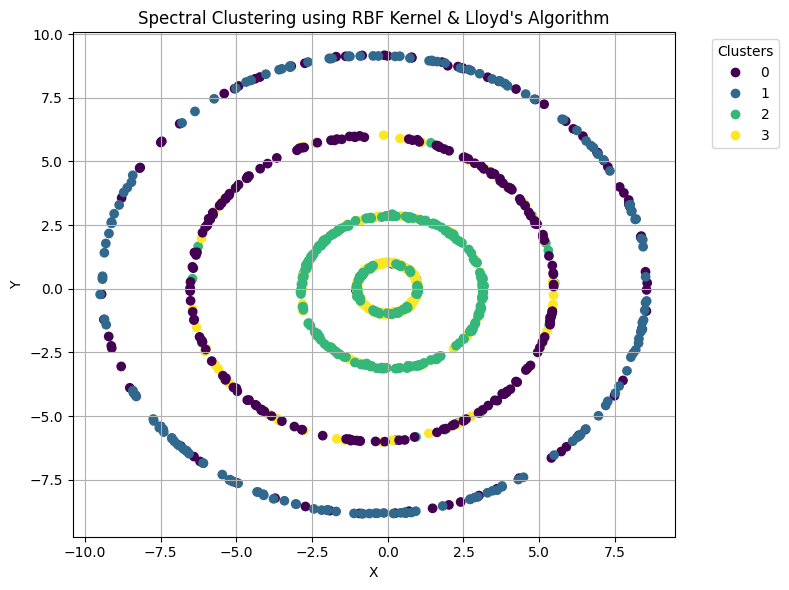

In [17]:
# init spectral clustering class with 4 cluster centers and RBF kernel
# gamma value is decided using parameter tuning 
# to enable high resolving ability between different clusters groups
sc = SpectralClustering(n_clusters=4, kernel='rbf', gamma=0)
# Carry out lloyd's clustering in kernelized space and return cluster labels
labels = sc.fit_predict(X)

# plot cluster assignment of data points
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spectral Clustering using RBF Kernel & Lloyd\'s Algorithm')
legend = plt.legend(*scatter.legend_elements(), title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

We use RBF Kernel (above) for the reasons that are listed below:

- The RBF kernel measures how close two points are and can reflect the local structure even when clusters are circular, concentric, or otherwise non-linear.
- Spectral clustering with the RBF kernel thus enables grouping points into rings, which traditional K-means cannot do because it assumes convex clusters based on straight-line distances.

## Spectral Clustering through row normalization

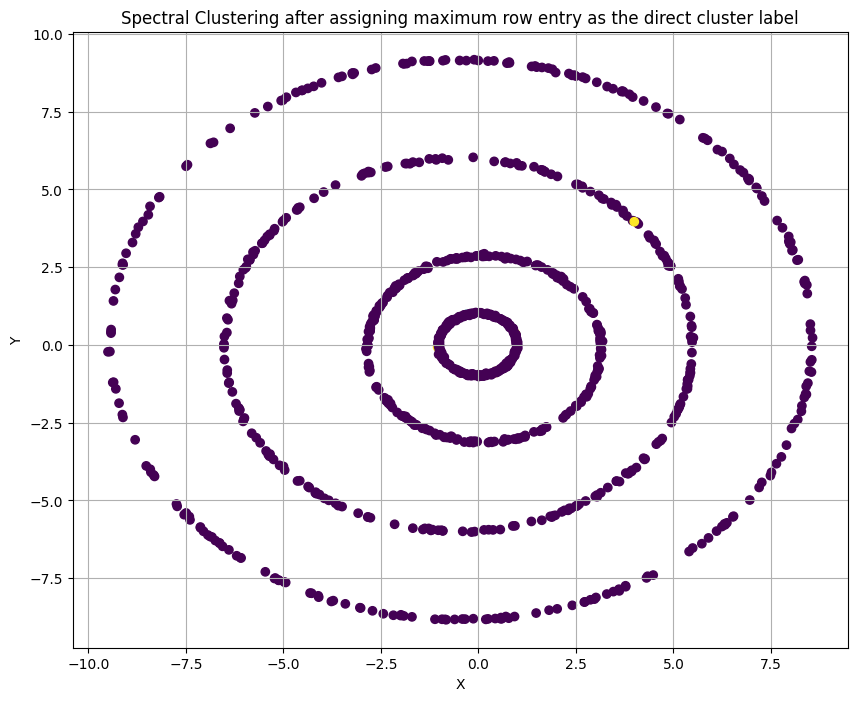

In [18]:
# Obtain direct cluster labels after spectral clustering
spectral_labels = sc.LaplacianClusters
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=spectral_labels, cmap='viridis')
plt.title('Spectral Clustering after assigning maximum row entry as the direct cluster label')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


This method leads to near complete loss of discrimination between cluster points. This could be due to the fact that kernelized data points have maximum value along a single component. On making cluster assignments based on this single component (having maximum component value), nearly all the points end up in the same cluster. The discrimination between clusters points is lost because we end up ignoring the information stored in other component of the each data point which is critical for maintining the distinction between data points from different clusters.

## Additional Exploration

Applying graph spectral clustering on the dataset

In [19]:
# derive the GSC class from KMeans to inherit the functionality of KMeans class 
class GraphSpectralClustering(KMeans):
    # Initialize
    def __init__(self, n_clusters, gamma):
        super().__init__(n_clusters=n_clusters, init='kmeans++')
        self.gamma = gamma
    
    # Transform the data using graph Laplacian
    def transform_features(self, X):
        n_samples = len(X)

        # initialize the kernel matrix
        K = np.zeros((n_samples, n_samples))
        
        # compute the kernel matrix
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = np.exp(-self.gamma * np.linalg.norm(X[i] - X[j])**2)

        # compute the graph Laplacian
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(K, axis=1)))
        L = np.eye(n_samples) - D_inv_sqrt @ K @ D_inv_sqrt
        # compute the eigenvalues and eigenvectors in increasing order of eigenvalues
        eigenvalues, eigenvectors = np.linalg.eigh(L)
        # Use first k eigenvectors (corresponding to k smallest eigenvalues)
        indices = np.argsort(eigenvalues)[:self.n_clusters]
        U = eigenvectors[:, indices]
        
        # Normalize rows to unit length
        norm = np.linalg.norm(U, axis=1, keepdims=True)
        U_normalized = U / np.maximum(norm, 1e-10)

        # return the normalized matrix
        # rows of this matrix are data points in kernel transformed feature space
        return U_normalized
    
    def fit_predict(self, X):
        # Apply LLoyd's clustering algorithm kernel transformed data points
        # use Kmeans++ initialization
        return super().fit_predict(self.transform_features(X))

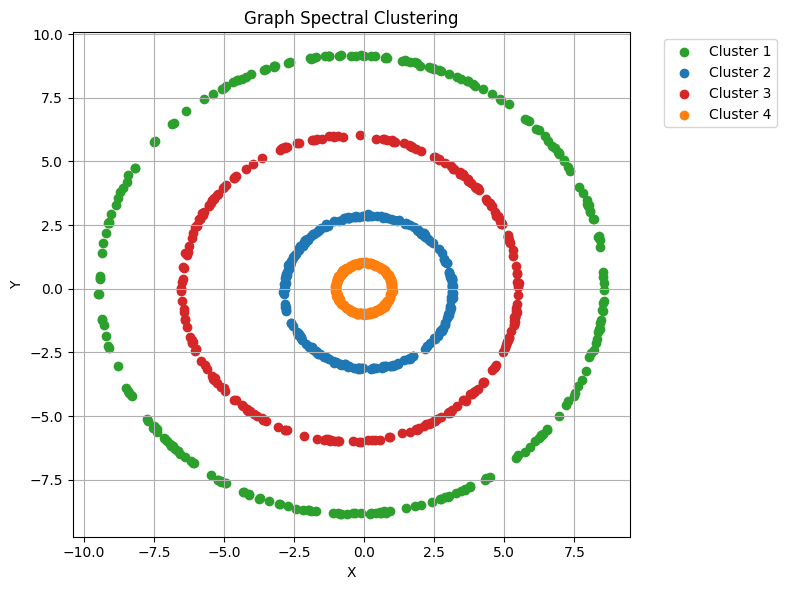

In [20]:
# create graph spectral clustering object
gsc = GraphSpectralClustering(n_clusters=4, gamma=10)
# obtain labels for each data point in X
labels = gsc.fit_predict(X)
    
# Create a scatter plot with shuffled colors
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.random.permutation(np.arange(4)))
for i in range(4):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], color=colors[i], label=f'Cluster {i+1}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Graph Spectral Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.tight_layout()
plt.show()